# **Import Library**

In [4]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Dropout,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

warnings.simplefilter("ignore")

# **Dataset Preparation**

In [5]:
sdir = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits"
bad_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits"
good_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Good Quality_Fruits"
mixed_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Mixed Qualit_Fruits"
filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + "_mixed")
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df

,filepaths,labels
0,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
1,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
2,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
3,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
4,../input/fruitnet-indian-fruits-dataset-with-q...,Guava_Bad
...,...,...
19521,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed
19522,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed
19523,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed
19524,../input/fruitnet-indian-fruits-dataset-with-q...,Banana_mixed


In [6]:
trsplit = 0.9
vsplit = 0.05
dsplit = vsplit / (1 - trsplit)
strat = df["labels"]
train_df, dummy_df = train_test_split(df,
                                      train_size=0.9, 
                                      shuffle=True, 
                                      random_state=123, 
                                      stratify=strat)
strat = dummy_df["labels"]
test_df, valid_df = train_test_split(dummy_df, 
                                     train_size=dsplit, 
                                     shuffle=True, 
                                     random_state=123, 
                                     stratify=strat)
print(
    "train_df lenght: ",
    len(train_df),
    "  test_df length: ",
    len(test_df),
    "  valid_df length: ",
    len(valid_df),
)
classes = list(train_df["labels"].unique())
class_count = len(classes)
groups = df.groupby("labels")
print("{0:^30s} {1:^13s}".format("CLASS", "IMAGE COUNT"))
for label in train_df["labels"].unique():
    group = groups.get_group(label)
    samples = len(group)
    print("{0:^30s} {1:^13s}".format(label, str(len(group))))
wave = wt / samples
have = ht / samples
aspect_ratio = have / wave
print(
    "Average Image Height: ",
    have,
    "  Average Image Width: ",
    wave,
    "  Aspect ratio: ",
    aspect_ratio,
)

train_df lenght:  17573   test_df length:  976   valid_df length:  977
            CLASS               IMAGE COUNT 
           Lime_Bad                1085     
          Guava_Bad                1129     
       Pomegranate_Good            5940     
          Lime_Good                1094     
          Apple_Bad                1141     
          Orange_Bad               1159     
          Guava_Good               1152     
          Apple_Good               1149     
         Orange_Good               1216     
         Banana_mixed               285     
         Banana_Good               1113     
          Banana_Bad               1087     
       Pomegranate_Bad             1187     
         Guava_mixed                148     
         Lemon_mixed                278     
      Pomegranate_mixed             125     
         Apple_mixed                113     
         Orange_mixed               125     
Average Image Height:  721.152   Average Image Width:  702.528   Aspect ra

In [7]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [8]:
max_samples=200
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)

Original Number of classes in dataframe:  18
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 133, 113, 113, 102]


In [9]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,
                           rotation_range=20, 
                           width_shift_range=.2,
                           height_shift_range=.2, 
                           zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  
                                            x_col='filepaths', 
                                            y_col=None, 
                                            target_size=image_size,
                                            class_mode=None, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            save_to_dir=target_dir, 
                                            save_prefix='aug-', 
                                            color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

In [10]:
working_dir=r'./'
img_size=(224,224)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  18
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 133, 113, 113, 102]
Found 133 validated image filenames.
Found 113 validated image filenames.
Found 102 validated image filenames.
Found 113 validated image filenames.
Total Augmented images created=  339
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [11]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (300,233) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,
                         rotation_range=20, 
                         width_shift_range=.2,
                         height_shift_range=.2, 
                         zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, 
                                    x_col='filepaths', 
                                    y_col='labels', 
                                    target_size=img_size,
                                    class_mode='categorical', 
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size)
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, 
                                          x_col='filepaths', 
                                          y_col='labels', 
                                          target_size=img_size,
                                          class_mode='categorical', 
                                          color_mode='rgb', 
                                          shuffle=False, 
                                          batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, 
                                         x_col='filepaths', 
                                         y_col='labels', 
                                         target_size=img_size,
                                         class_mode='categorical', 
                                         color_mode='rgb', 
                                         shuffle=False, 
                                         batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 3600 validated image filenames belonging to 18 classes.
Found 977 validated image filenames belonging to 18 classes.
Found 976 validated image filenames belonging to 18 classes.
test batch size:  61   test steps:  16  number of classes :  18
       class name        class index 
        Apple_Bad             0      
       Apple_Good             1      
       Apple_mixed            2      
       Banana_Bad             3      
       Banana_Good            4      
      Banana_mixed            5      
        Guava_Bad             6      
       Guava_Good             7      
       Guava_mixed            8      
       Lemon_mixed            9      
        Lime_Bad              10     
        Lime_Good             11     
       Orange_Bad             12     
       Orange_Good            13     
      Orange_mixed            14     
     Pomegranate_Bad          15     
    Pomegranate_Good          16     
    Pomegranate_mixed         17     


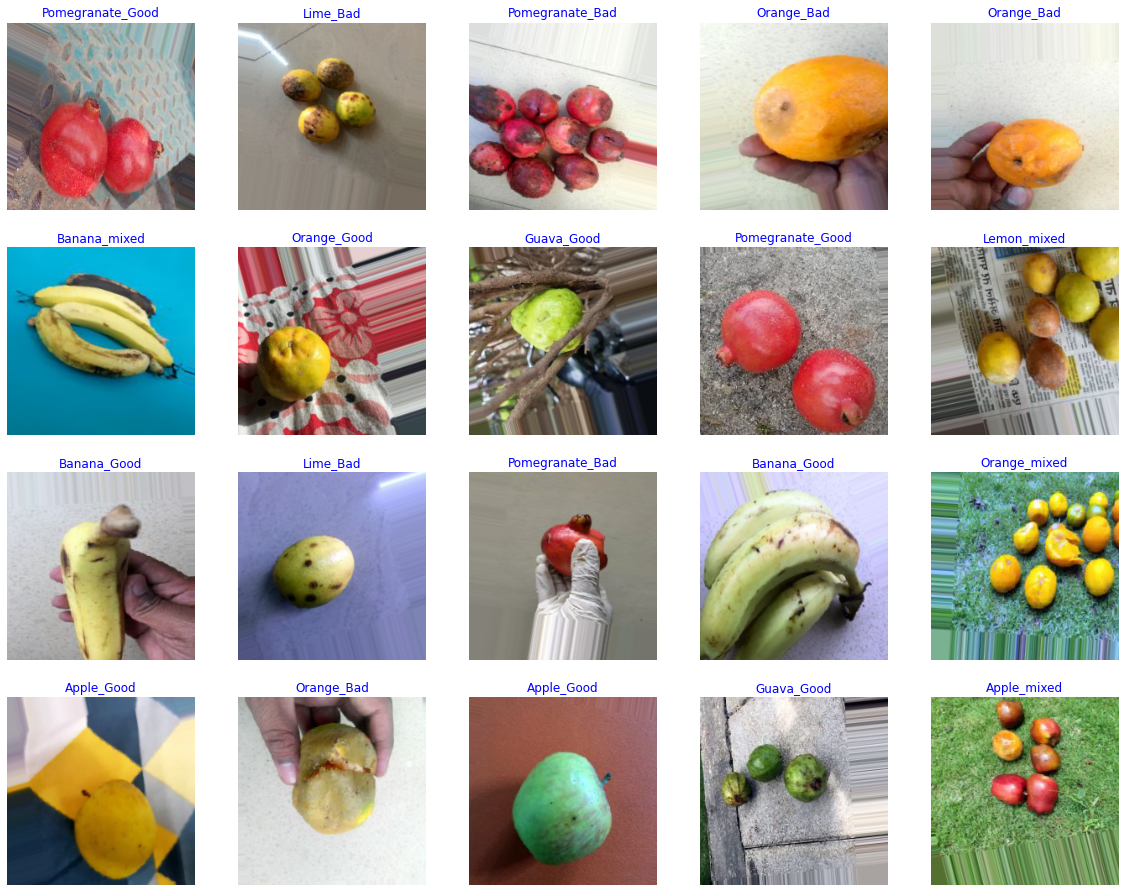

In [12]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [13]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

2022-11-16 03:01:46.208201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:01:46.209329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:01:46.646250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:01:46.647174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:01:46.647981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

219070464/219055592 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop]

In [16]:
epochs=10
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False,
    initial_epoch=0,
    callbacks=callbacks
)

2022-11-16 03:01:58.839212: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-16 03:02:18.557113: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


180/180 [==============================] - 140s 597ms/step - loss: 21.2655 - accuracy: 0.5444 - val_loss: 16.2667 - val_accuracy: 0.8506
Epoch 2/10
180/180 [==============================] - 93s 517ms/step - loss: 12.9575 - accuracy: 0.8544 - val_loss: 11.5519 - val_accuracy: 0.9191
Epoch 3/10
180/180 [==============================] - 93s 518ms/step - loss: 8.5033 - accuracy: 0.9025 - val_loss: 7.0914 - val_accuracy: 0.9437
Epoch 4/10
180/180 [==============================] - 94s 519ms/step - loss: 5.8017 - accuracy: 0.9186 - val_loss: 5.5867 - val_accuracy: 0.9345
Epoch 5/10
180/180 [==============================] - 93s 518ms/step - loss: 4.1164 - accuracy: 0.9278 - val_loss: 3.2458 - val_accuracy: 0.9754
Epoch 6/10
180/180 [==============================] - 94s 519ms/step - loss: 2.9073 - accuracy: 0.9631 - val_loss: 2.3825 - val_accuracy: 0.9601
Epoch 7/10
180/180 [==============================] - 94s 519ms/step - loss: 2.1621 - accuracy: 0.9725 - val_loss: 1.7922 - val_accuracy

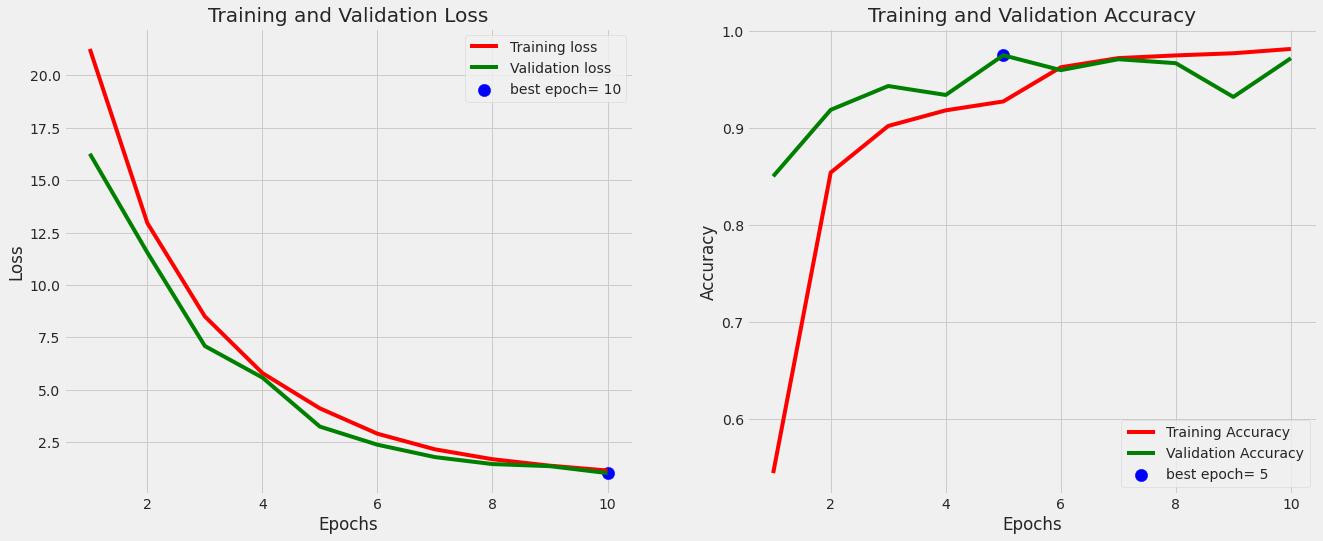

In [17]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [18]:
loss, accuracy = model.evaluate(test_gen)
print('Test accuracy :', accuracy)

16/16 [==============================] - 20s 1s/step - loss: 1.0219 - accuracy: 0.9723
Test accuracy : 0.9723360538482666


In [19]:
!mkdir -p saved_model
model.save('my_model.h5')